# Neural Network from Scratch

In this exercise, we will use a simple neural network and code it from scratch, without relying on any external libraries.

In practice, we would, of course, not do this as this would be a very difficult way to write efficient and flexible code that requires extensive debugging.

We will create a small neural network with just one hidden layer that can be used for classification. The general setup is:
* input layer: one node per variable
* hidden layer: number of nodes as a free parameter
* output layer: number of nodes according to number of target classes.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

#for logistic sigmoid function (a.ka. expit)
from scipy.special import expit

# import of sigmoid and crossentropy
from scipy.special import expit
from sklearn.metrics import log_loss


import matplotlib.pyplot as plt
import numpy as np
from keras.datasets import mnist
from keras.utils.np_utils import to_categorical
np.random.seed(1234)
%matplotlib inline
import sys

## Iris Dataset
This example will use the popular "Iris" dataset.

The [Iris dataset](http://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html) was [originally introduced](http://en.wikipedia.org/wiki/Iris_flower_data_set) by Sir Robert Fisher in 1936 as an example for discriminant analysis.
The data focus on how to discriminate between three different types of the [iris flower](http://en.wikipedia.org/wiki/Iris_(plant) ):

* Setosa, 
* Versicolour, and
* Virginica

Each row in the dataset contains the following features (measured in cm):

* Sepal Length, 
* Sepal Width, 
* Petal Length, and 
* Petal Width.

The labels (true values) are mapped as integers in $[0,1,2]$ for the three different flower types. We will transform this via one-hot encoding to make the computations regarding the loss function easier later.

As this is a popular dataset, it is contained in various machine learning packages.
Here we use the data from the [SciKit-Learn](https://scikit-learn.org/stable/) machine learning suite.

Note that the dataset is quite small with only 150 observations. However, it has the benefit that the subsequent processing and network training is very fast, and it serves us well to illustrate the principles.

In [ ]:
from sklearn.datasets import load_iris
iris = load_iris()
print('number of samples: {}'.format(len(iris.data)))

number of samples: 150


In [ ]:

# access the data and split into helper arrays.
x1 = iris.data
y1 = iris.target

# The samples are ordered by target class # in the original dataset. 
# As a first step, we shuffle the order before splitting the data into
# training and test data
perm = np.random.permutation(x1.shape[0])
y2 = y1[perm]
x2 = x1[perm,:]

# now we take 90% of the data for trainig and 10% for testing
frac_train = 0.9
train_index = int(round(len(iris.data)*frac_train))
X_train = x2[0:train_index]
X_test  = x2[train_index+1 :]

y_train = y2[0:train_index]
y_test  = y2[train_index+1 :]

# convert the class number into one-hot encoding.
# e.g. target class 2 -> [0,0,1]
n_classes = 3
y_train = to_categorical(y_train, n_classes)
y_test = to_categorical(y_test, n_classes)

## Forward and Backward Pass for Backpropagation

This is the core of the neural network training. During the forward
pass we use the current settings of the weights and calculate the network response. During the backward pass in backpropagation, we comparet the output to the desired output and calculate the change of the weights.

Note that we train the network such that during each weight update or learning step we present a batch of input signals to the network instead of just one.
For example, if we have four input variables, we do not just present ($x_1,x_2,x_3,x_4$) to the network to learn from this pattern, but each of $x_1,x_2,x_3$, and $x_4$ is a vector itself that contains $n$ training samples.

### Forward Pass
We need to calculate the response of the network.
In our small network, we only need to compute the path from the input to the hidden layer and from the hidden to the output layer.

* Input to hidden layer: 
$a_1 = W_1 x + b_1$, $h_1 = f(a_1)$ where $f(.)$ is the activation function for the hidden layer. We will use the tanh(x) function here.

* Hidden to output layer: 
$a_2 = W_2 h_1 +  b_2$, $\hat{y} = f_y(a_2)$ where $f_y(.)$ is the activation function for the output layer. We will use the sigmoid function here because it is more convenient in the backward pass.
The sigmoid function is given by: $ \sigma(x) = \frac{1}{1+e^{-x}}$

### Backward Pass (Backpropagation)
The backward pass calculates the changes of the weights. We start by comparing how different the output of the current neural network (from the forward pass) is compared to what we expect (the true labels).

Because we transformed the labels into one-hot encoded signals, we essentially perform three classifications at once: class 1: yes/no, class 2: yes/no, class 3: yes/no, one for each node.
For a single classification, the cross entropy or [log loss](https://scikit-learn.org/stable/modules/model_evaluation.html#log-loss) is given by:
LogL $= - (y \log(\hat{y}) + (1-y) \log(1-\hat{y}))$ where $y \in {0,1}$ is the true label and $\hat{y}$ is the prediction of the network. Since we use the sigmoid function, this is given by $p=\sigma(x)$

Recall that for the output layer the gradient used in the weight update is given by $\frac{\partial E}{\partial W} = \frac{\partial E}{\partial \hat{y}} \frac{\partial \hat{y}}{\partial \xi} \frac{\partial \xi}{\partial W}$.
Here, $\xi$ is the output of the layer prior to the activation function, i.e.,
$\xi = Wo_{i-1}+b$ and hence $\frac{\partial \xi}{\partial W} = o_{i-1}$, i.e.,
the output of the previous layer. 
Using the chain rule, the first two partial derivatives evaluate to $y - \hat{y}$ due to the special structure of the derivative of the sigmoid function (in fact, this is why we chose it here):  $\sigma^\prime(x) = \sigma(x) \left ( 1- \sigma(x) \right ) $
Hence the change of the weights is given by $\delta W_2 = - (y-\hat{y})h_1^T$
since we only have one hidden layer (denoted by $h_1$) and we need the transpose to do the matrix multiplication properly.

The change of weights for the first (input) layer is calculated
in the same way using the error term $W_2^T (y-\hat{y})$ and the derivative of the tanh(x) function used as activation function in the hidden layer ($\tanh^\prime(x) = 1 - \tanh^2(x) $).

For the biases $b_1$ and $b_2$, we can imagine that this is a special connection where the previous neuron  has a constant activation that is equal to one. Hence the backpropagation rule is reduced to delta_b = - learn_rate * 1 * error


In [ ]:
#
# Forward pass: calculate network response
# N.B. need to append as many components to the bias b1 and b2
#      as we have elements in each training batch using np.tile 
def forward_pass(W1, W2, b1, b2, x):
  #input to hidden layer
  a1 = np.matmul(W1,x) + np.tile(b1, x.shape[1])  
  h1 = np.tanh(a1)

  #hidden to outpt layer
  a2 = np.matmul(W2, h1) + np.tile(b2, x.shape[1])

  #output layer has sigmoid activation
  y_hat = expit(a2)

  return a1, h1, a2, y_hat

#
# Backward pass: calculate changes to weights
#
def backward_pass_backprop(e, h1, W2, a1, x):
  dW2 = -np.matmul(e, np.transpose(h1))                  
  da1 =  np.matmul(np.transpose(W2),e)*(1-np.tanh(a1)**2) 
  dW1 = -np.matmul(da1, np.transpose(x))                  

  # change in bias b1 and b2:
  db2 = -np.sum(e, axis=1)
  db1 = -np.sum(da1, axis=1)

  return dW1, dW2, db1[:, np.newaxis], db2[:,np.newaxis]

## Network training

We now write the training loop for the small network.
The general structure is:
* loop over the number of epochs or training iteration
 * within each epoch, loop over all batches
 * compute the current network output (forward pass)
 * compute the error by comparing the output to the true labels
 * calculate the change of weights (backward pass)

In [ ]:
#
# Network parameters
#
n_input  = 4
n_hidden = 100
n_output = n_classes

batch_size = 32
learn_rate = 1e-4
n_epochs   = 100

# we need to change the shape of the data from a long array 
# with four variables per observation to an array with the four
# input variables, each with the observations (per variable)
# and accordingly for the output for the calculations of the weights.
x = np.transpose(X_train)
y = np.transpose(y_train)

#
# initialize network weights
#
W1 = np.random.randn(n_hidden, n_input)
W2 = np.random.randn(n_output, n_hidden)

b1 = np.random.randn(n_hidden, 1)
b2 = np.random.randn(n_output, 1)

dataset_size = x.shape[1]
n_batches = dataset_size//batch_size
print('Dataset size: {}, batch_size: {}, number of batches {}'.format(dataset_size, batch_size, n_batches))

# save the total error for each epoch, summed over all batches
train_error_epoch = []



for i in range(n_epochs):
  #shuffle training data
  perm = np.random.permutation(x.shape[1])
  x = x[:, perm]
  y = y[:, perm]

  # value of loss function and training error
  loss = 0.0
  train_error = 0.0

  #
  # loop over batches
  #
  for j in range(n_batches):
    train_data = x[:, j*batch_size:(j+1)*batch_size]
    targets    = y[:, j*batch_size:(j+1)*batch_size]
    #
    # forward pass
    #
    a1, h1, a2, y_hat = forward_pass(W1=W1, W2=W2, b1=b1, b2=b2, x=train_data)

    # metrics
    error = y_hat - targets

    # due to one-hot encoding, each prediction and true label is an array
    # recover the class number via np.argmax
    preds = np.argmax(y_hat, axis=0) 
    truth = np.argmax(targets, axis=0)

    # error is the difference between prediction and true, summed over
    # all elements in the batch
    train_error += np.sum(preds!=truth)

    # cross entropy loss
    loss_on_batch = log_loss(targets, y_hat)

    #
    # calculate change of weights - backward pass
    #
    dW1, dW2, db1, db2 = backward_pass_backprop(e=error, h1=h1, W2=W2, a1=a1, x=train_data)

    #weight update
    W1 += learn_rate * dW1
    W2 += learn_rate * dW2
    b1 += learn_rate * db1
    b2 += learn_rate * db2
    loss += loss_on_batch

  #update errors per epoch
  training_error = 100.*train_error/x.shape[1]
  train_error_epoch.append(training_error)

Dataset size: 135, batch_size: 32, number of batches 4


Plot the training error as the training progresses for each epoch

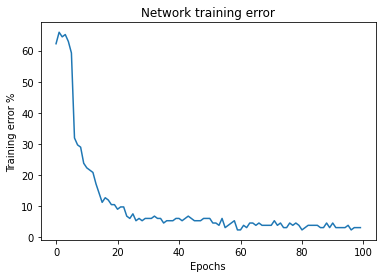

In [ ]:
x = range(0,n_epochs)
plt.plot(x, train_error_epoch, label='training error')
plt.title('Network training error')
plt.xlabel('Epochs')
plt.ylabel('Training error %')
#plt.legend(loc='best')
plt.show()

Check the predictions with the independent test sample

In [ ]:
test_samples = np.transpose(X_test)
test_targets = np.transpose(y_test)
    
y_hats = forward_pass(W1, W2, b1, b2, test_samples)[-1]
preds = np.argmax(y_hats, axis=0) 
truth = np.argmax(test_targets, axis=0)
test_error = 1.*np.sum(preds!=truth)/preds.shape[0]

print('Test error:', test_error, '%')

Test error: 0.0 %
